# 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 
λを用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

$$
λ
_{newi}
=λ
_i
+
α
(1−n∑_j=1λ_jy_i
y
_j
k
(
x
_i
,
x
_j
)
)
$$ 
ここで 
k
(
x_i
,
x_j
)
 はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。

$$
k
(
x
_i
,
x
_j
)
=
x
T
_i
x
_j
$$
条件として、更新毎に 
λ
_i
>=
0
を満たす必要があります。満たさない場合は 
λ
i
=
0
とします。

$$ 
i
,
j
 : サンプルのインデックス


λ
_new_i
 : 更新後のi番目のサンプルのラグランジュ乗数


λ_i
 : 更新前のi番目のサンプルのラグランジュ乗数


α
 : 学習率


λ_j
 : j番目のサンプルのラグランジュ乗数


y_i
 : i番目のサンプルのラベル


y_j
 : j番目のサンプルのラベル


x_i
 : i番目のサンプルの特徴量ベクトル


x_j
 : j番目のサンプルの特徴量ベクトル
$$ 

あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。



In [458]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue
    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数（線を引く時の最小値の数）
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.support_vector = []
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.lam_sv = np.random.rand(X.shape[0], 1)
        
        for i in range(self.iter):
            self._upgrade_svm(X, y)
        
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print('{}/{} lamda{}'.format(i+1, self.iter, self.lam_sv.max()))
        
         # サポートベクターを決定しインデックスとして保存する
        self.support_vector = np.where(self.lam_sv >= self.threshold)
        
        # 問題3の計算をここで保存する（yの値が必要なのでpredictで実装すると引数にyが必要）
        support_vector = self.support_vector[0]
        
        # 最終(n,25)  (75,2 2,75)
        self.kernel_sv =  X[support_vector]@X.T
        
        # 最終(1,n)
        self.calucation = self.lam_sv[support_vector].T*y[support_vector] #λ*y (45, 1)
        #print(support_vector)
        #print(y[support_vector].shape)
        #print(np.dot(X[support_vector],X.T).shape)
        #print('self.lam_sv[support_vector].T', self.lam_sv[support_vector].T.shape)
        #print('y[support_vector] ', y[support_vector].shape)
        #print(self.calucation.shape)
        #print("suport vector", support_vector)
        #print("kernel_sv", self.kernel_sv)
        #print("kernel_sv", self.kernel_sv.shape)
        #print("suport vector", self.calucation)
        #print("suport vector", self.calucation.shape)
        
        
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        f_x = self.calucation@self.kernel_sv.T #(1,n),(n,25) (1,25)
        f_x = np.where(f_x <0, -1, 1) # (25, )か(1,25)
        return f_x 
    
    def _upgrade_svm(self, X, y):
        # y_dot = (100,100) 
        # self.lam_sv = (100,1) 
        #np.dot(self.lam_sv, y_dot) = (100,1)
        # _kernel(X) = (100,100)
        y_dot = y@y.T # (100,1) (1,100)
        self.lam_sv = self.lam_sv + self.lr*(1 - (np.sum(self.lam_sv.T@(y_dot*kernel(X))))) #計算の順番注意
        self.lam_sv = np.where(self.lam_sv< 0, 0, self.lam_sv) # ０以下を０に変換する
            
    def _kernel(self, X):
        kernel = X@X.T  # (100,1), X(1,100) (100,100)
        return kernel
    

In [459]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
X = X.loc[:, ['sepal length (cm)','sepal width (cm)']][0:100].to_numpy()
y = iris.target[0:100]

a = np.random.rand(X.shape[0], 1)
b = np.arange(0,12).reshape(3,4)
c = np.arange(0,15).reshape(3,5)
where = np.where(c%2==0)
print(where)
print(c)
c[where]

(array([0, 0, 0, 1, 1, 2, 2, 2]), array([0, 2, 4, 1, 3, 0, 2, 4]))
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]


array([ 0,  2,  4,  6,  8, 10, 12, 14])

In [460]:
def gradient(X, y, lr=0.0001, threshold=1e-5):
    # y_dot = (100,100) 
    # self.lam_sv = (100,1) 
    #np.dot(self.lam_sv, y_dot) = (100,1)
    # _kernel(X) = (100,100) 
    np.random.seed(0)
    lam_sv = np.random.rand(X.shape[0], 1)
    y = y.reshape(-1,1)
    for i in range(1000):
        y_dot = np.dot(y, y.T) # (100,1) (1,100)  (100,100)
        lam_sv = lam_sv + lr*(1 - np.sum(np.dot(lam_sv.T, (y_dot*kernel(X)))))
        lam_sv = np.where(lam_sv <= 0, 0, lam_sv)
        support_vector = np.where(lam_sv >= threshold)
        return lam_sv, support_vector


def kernel(X):
    kernel = np.dot(X, X.T)  # (100,2), X(2,100) (100,100)
    return kernel

a, b = gradient(X,y)
a.ravel()

array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001])

# 【問題2】サポートベクターの決定
計算したラグランジュ乗数 $\lambda$ が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。



In [ ]:
for i in range(self.iter):
            self._upgrade_svm(X, y)
        
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print('{}/{} lamda{}'.format(i+1, self.iter, self.lam_sv.max()))
        
         # サポートベクターを決定しインデックスとして保存する
        self.support_vector = np.where(self.lam_sv >= self.threshold)
        
        # サポートベクターの2次元のインデックスを保存する
        # 問題3の計算をここで保存する（yの値が必要なのでpredictで実装すると引数にyが必要）
        self.support_vector = self.support_vector[0]
        print(self.support_vector)
        # 最終(n,25)  (75,2 2,75) 
        self.kernel_sv = X[self.support_vector]
        self.y = y[self.support_vector]
        self.lamda = self.lam_sv[self.support_vector]

# 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 
f
(
x
)
 の符号が分類結果です。

In [ ]:
def predict(self, X):
        
        '''
        SVM分類器を使いラベルを推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        '''
        #X(25,2) self.kernel_sv (75, 2) 
        #self.kernel_sv (75, 2)
        #self.y (75, 1)
        #self.lamda (75, 1)
        kernel = X@self.kernel_sv.T #(25,75) 
        # (75,1) (25,75)
        f_x = np.dot((self.lamda*self.y).T, kernel.T)
        f_x = np.where(f_x <0, -1, 1) # (25, )か(1,25)
        return f_x 

In [606]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue
    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数（線を引く時の最小値の数）
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    """
    
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose

        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.lam_sv = np.random.rand(X.shape[0], 1)
        y = y.reshape(-1,1)
        
        for i in range(self.iter):
            self._upgrade_svm(X, y)
        
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print('{}/{} lamda{}'.format(i+1, self.iter, self.lam_sv.max()))
        
         # サポートベクターを決定しインデックスとして保存する
        self.support_vector = np.where(self.lam_sv >= self.threshold)
        
        # サポートベクターの2次元のインデックスを保存する
        # 問題3の計算をここで保存する（yの値が必要なのでpredictで実装すると引数にyが必要）
        self.support_vector = self.support_vector[0]
        print(self.support_vector)
        # 最終(n,25)  (75,2 2,75) 
        self.kernel_sv = X[self.support_vector]
        self.y = y[self.support_vector]
        self.lamda = self.lam_sv[self.support_vector]
        print('self.kernel_sv', self.kernel_sv.shape)
        print('self.y',self.y.shape)
        print('self.lamda', self.lamda.shape)
        #(75, 2) (2, 25)=(75, 25)
        
        
        #最終(1,n) λ* y
        #self.calucation = self.lam_sv[self.support_vector]* # (75,1) (75,1)
        #print(self.support_vector.shape)
        #print(self.lam_sv)
        #print(self.lam_sv[self.support_vector])
        #print(self.lam_sv[self.support_vector].shape)
        #print(y[support_vector].shape)
        #print(np.dot(X[support_vector],X.T).shape)
        #print('self.lam_sv[support_vector].T', self.lam_sv[support_vector].T.shape)
        #print('y[support_vector] ', y[support_vector].shape)
        #print(self.calucation.shape)
        #print("suport vector", support_vector)
        #print("kernel_sv", self.kernel_sv)
        #print("kernel_sv", self.kernel_sv.shape)
        #print("suport vector", self.calucation)
        #print("suport vector", self.calucation.shape)
        
        
    def predict(self, X):
        
        '''
        SVM分類器を使いラベルを推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        '''
        #X(25,2) self.kernel_sv (75, 2) 
        #self.kernel_sv (75, 2)
        #self.y (75, 1)
        #self.lamda (75, 1)
        kernel = X@self.kernel_sv.T #(25,75) 
        # (75,1) (25,75)
        f_x = np.dot((self.lamda*self.y).T, kernel.T)
        f_x = np.where(f_x <0, -1, 1) # (25, )か(1,25)
        return f_x 
    
    def _upgrade_svm(self, X, y):
        # y_dot = (100,100) 
        # self.lam_sv = (100,1) 
        # np.dot(self.lam_sv, y_dot) = (100,1)
        # _kernel(X) = (100,100)
        
        y = y.reshape(-1,1)
        y_dot = y*y.T # (100,1) (1,100) 
        self.lam_sv = self.lam_sv + self.lr*(1 - (np.sum(self.lam_sv*y_dot*self._kernel(X), axis=1)).reshape(-1,1)) #計算の順番注意
        #self.lam_sv = self.lam_sv
        #print(self.lam_sv.shape)
        #print(self.lam_sv)
        
        self.lam_sv = np.where(self.lam_sv< 0, 0, self.lam_sv) # ０以下を０に変換する
        #print(self.lam_sv.shape)
    
    def _kernel(self, X):
        kernel = X@X.T  # (100,1), X(1,100) (100,100)
        return kernel
    

# 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [650]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(iris.data, columns=iris.feature_names)
X = X.loc[:, ['sepal length (cm)','sepal width (cm)']][0:100].to_numpy()
y = iris.target[0:100]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model_sc = ScratchSVMClassifier(1000,0.0001, threshold=0.5, verbose=None)

model_sc.fit(X_train,y_train)



[ 3  5  6  7  8 10 13 16 17 19 22 24 27 28 29 38 46 52 56 58 61 63 69 72]
self.kernel_sv (24, 2)
self.y (24, 1)
self.lamda (24, 1)


In [644]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X_train, y_train)
pred = model.predict(X_test)
pred

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1])

In [648]:
pred = model_sc.predict(X_test)
pred = pred.flatten()
print(pred)

print(confusion_matrix(pred,y_test))
print(accuracy_score(pred,y_test))
print(precision_score(pred, y_test))
print(recall_score(pred, y_test))
print(f1_score(pred, y_test))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 0  0]
 [14 11]]
0.44
1.0
0.44
0.6111111111111112


# 【問題5】決定領域の可視化
決定領域を可視化してください。


以下の例のようにサポートベクターは異なる色で示してください。

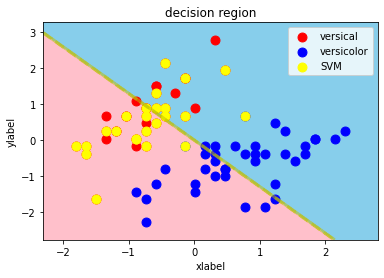

In [651]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versical', 'versicolor']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    #plt.scatter(X[svm.ind[0],0],X[svm.ind[0],1], s=80, color='yellow', label='SV', marker='o')
    plt.scatter(X[model_sc.support_vector, 0],X[model_sc.support_vector, 1], s=80, color='yellow', label='SVM', marker='o') 
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()
    
decision_region(X_train, y_train, model_sc)